<a href="https://colab.research.google.com/github/KenichiQaz/ML_Learning/blob/main/own_try11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from IPython.display import display,HTML

     |████████████████████████████████| 719 kB 7.7 MB/s 
     |████████████████████████████████| 4.7 MB 47.9 MB/s 
     |████████████████████████████████| 1.3 MB 63.8 MB/s 
     |████████████████████████████████| 365 kB 74.4 MB/s 
     |████████████████████████████████| 120 kB 71.5 MB/s 
     |████████████████████████████████| 212 kB 70.6 MB/s 
     |████████████████████████████████| 115 kB 73.0 MB/s 
     |████████████████████████████████| 127 kB 77.3 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
Mounted at /content/gdrive


# Data Munging

In [2]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [3]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

# Transforms

In [4]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [5]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#518) ['xxbos','i','ca','nt','understand','at','all','why','so','many'...]

In [6]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,   18,  176, 1253,  376,   43,   46,  127,   47,  152])

In [7]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','i','ca','nt','understand','at','all','why','so','many']

In [8]:
tok.decode(nums_dec)

'xxbos i ca nt understand at all why so many'

In [9]:
tok((txts[0], txts[1]))

((#518) ['xxbos','i','ca','nt','understand','at','all','why','so','many'...],
 (#207) ['xxbos','xxmaj','harsh',',','yes',',','but','i','call',"'em"...])

# Custom Transform

In [10]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [11]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

In [12]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [13]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

# Create Pipeline

In [14]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,   18,  176, 1253,  376,   43,   46,  127,   47,  152,    8, 3714,  578,  115,   20,   16,  772,   11,   44,   15])

In [15]:
tfms.decode(t)[:100]

'xxbos i ca nt understand at all why so many xxmaj godzilla fans think this is excellent , one of the'

In [16]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [17]:
t = tls[0]; t[:20]

TensorText([   2,   19,  197, 1142,  409,   46,   45,  157,   52,  130,    8, 3192,  468,  123,   20,   16,  346,   11,   44,   14])

In [18]:
tls.decode(t)[:100]

'xxbos i ca nt understand at all why so many xxmaj godzilla fans think this is excellent , one of the'

# TfmdLists and Datasets

### TfmdLists

In [19]:
tls.show(t)

xxbos i ca nt understand at all why so many xxmaj godzilla fans think this is excellent , one of the best xxmaj godzilla films ever in fact . xxmaj this film is horrible and one of the very few xxmaj gojira films i ca nt stand to watch again ( the other being xxup g. vs xxmaj xxunk ) . 

 xxmaj the plot is too campy to be in the xxmaj heisei series , a series that attempted to turn the aging xxmaj godzilla franchise into bonafide action films , revolving around ideas that seemed more in place in 1974 than 1991 . xxmaj it just sounded ridiculous , especially with some of the subject matter , take for example the xxup ww2 scene , with the xxmaj japanese soldiers praising a dying xxmaj xxunk , a mournful and serious tone , take the exuberant former commander turn capitalist and his death , serious xxunk in a film its fans somehow denote as played for laughs , as a goofy romp with guilty illogical fun , if so than this is easily one of the most tasteless films xxmaj i 've seen , however i 

In [20]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [21]:
tls.valid[0][:20]

TensorText([   2,   19,   59,   36,  141,  110,   19,   74,  252,   63,   19, 1405,   18,    7, 2440,   10,   19,   74,  127,   66])

In [22]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [23]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [24]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

### Datasets

In [25]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([   2,   19,  197, 1142,  409,   46,   45,  157,   52,  130,    8, 3192,  468,  123,   20,   16,  346,   11,   44,   14]),
 TensorCategory(0))

In [26]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([   2,   19,   59,   36,  141,  110,   19,   74,  252,   63,   19, 1405,   18,    7, 2440,   10,   19,   74,  127,   66]),
 TensorCategory(1))

In [27]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos i do n\'t know how i would feel if i lived in xxup usa . i would watch some preview scenes , advertisements , i would know , xxmaj sidney xxmaj pollack directed it , xxmaj harrison xxmaj ford and xxmaj kristin xxmaj scott xxmaj thomas starring in . i would watch this film as soon as possible without reading any bad review . xxmaj would i be disappointment ? \n\n i read a lot of review which is said how bad this film was : xxmaj this is boring , long film without passion emotions and it is not interesting . xxmaj harrison is wooden , cold . xxmaj the xxunk should be cut . xxmaj too serious , particularly for xxmaj harrison xxmaj ford . i am interested in the subject , and i like xxmaj harrison xxmaj ford in the films which are not actions . i like xxmaj sidney xxmaj pollack and xxmaj kristin xxmaj scott xxmaj thomas too . xxmaj so reading the reviews on xxup imdb website then in other sites then in xxmaj february in the xxmaj hungarian movie magazines i was wonder and wonder wha

In [28]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [29]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

In [30]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

# SiamesePair API

In [31]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [32]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

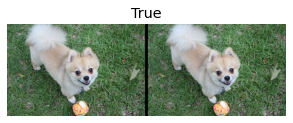

In [33]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

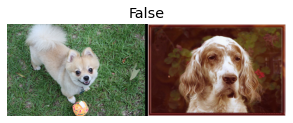

In [34]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

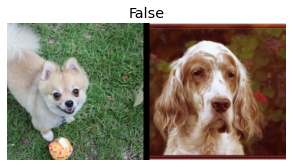

In [35]:
s2 = Resize(224)(s1)
s2.show();

In [36]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [37]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

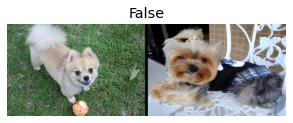

In [38]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

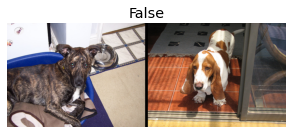

In [39]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [40]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])